In [10]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasting import TruncatedRNNRegressor
from pandas import read_table

%matplotlib inline

# Quickstart Tutorial

In this tutorial, we show how to quickly set up and train an RNN-based regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

## Data cleaning and preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [11]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')
length = len(df)
dimensionality = len(df.columns)

In [135]:
# Preprocess the data
test_length = 9  # test on the last 9 months
train_length = length - test_length
ts = df.values

# Standardize the data
means = ts[:train_length, :].mean(0)
stds = ts[:train_length, :].std(0)
ts_standardized = (ts - means) / stds

# Sanity check if data has correct format
assert ts_standardized.shape == ts.shape and np.sum(np.isnan(ts_standardized)) == 0

In [136]:
# Generate X and y numpy arrays for train/test sets
# Set sequence length for truncated sample time series
sequence_length = 20 # i.e. 20 months

# Prepare train and test data
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(train_length - sequence_length):
    X_train.append(ts_standardized[i:i+sequence_length])
    y_train.append(ts_standardized[i+sequence_length])

for i in range(-test_length, 0):
    y_test.append(ts_standardized[i])
    X_test.append(ts_standardized[i-sequence_length:i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
# Xs are 3D tensors of shape number of sequences * sequence length * dim
# ys are 2D tensors of shape number of sequences * dim

def compute_mape(model, x, y):
    forecasts = model.predict(x, batch_size=len(x))
    forecasts = (forecasts * stds) + means
    y_denom = (y * stds) + means
    return np.mean(np.abs((y_denom - forecasts) / y_denom))*100.0
    
def criticize(model, metric=compute_mape):
    print('TRAIN \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, X_train, y_train)))
    print('TEST \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, X_test, y_test)))

Before we do anything, we should probably have a quick look at a visualization of the data

Text(0.5,1,'Black: training time series; Red: testing time series')

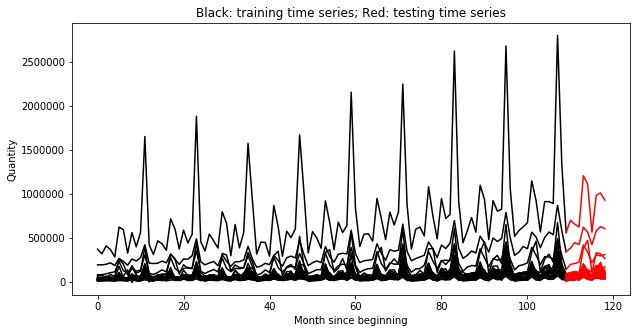

In [137]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length], 'k')
plt.plot(range(len(ts[:train_length-1]), len(ts)), ts[train_length-1:], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Recurrent Neural Network Regression

Now that we have cleaned and prepared out dataset we can proceed to fit one of our built-in regression models. Here, we choose the truncated RNN, which means that the training example time series have finite length. The model is initalized with a topology object, a batch size that determines the number of training example fed into the optimizer per training batch, and a number of epochs that specifies how many trianing batches are processed.

In [138]:
# Hyper-parameters
topology = [32]
batch_size = 8
epochs = 50

# Instantiate regression model
model = TruncatedRNNRegressor(topology=topology, batch_size=batch_size, epochs=epochs)
model.fit(X_train, y_train)

Let's have a peek at what the model training and testing errors look like

In [139]:
criticize(model)

TRAIN 	 Mean Absolute Percentage Error: 16.0%
TEST 	 Mean Absolute Percentage Error: 14.3%


Let's have a look at the history of the training loss (here mean-squared error)

Text(0,0.5,'Mean-squared training error')

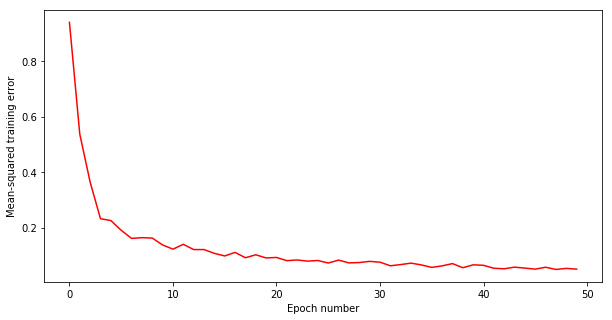

In [140]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(model.history.epoch, model.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

## Predictions

Let's now take the model to make some predictions and compare visually with the test data.

In [141]:
y_pred = model.predict(X_test, batch_size=len(X_test))
ts_pred = y_pred*stds + means

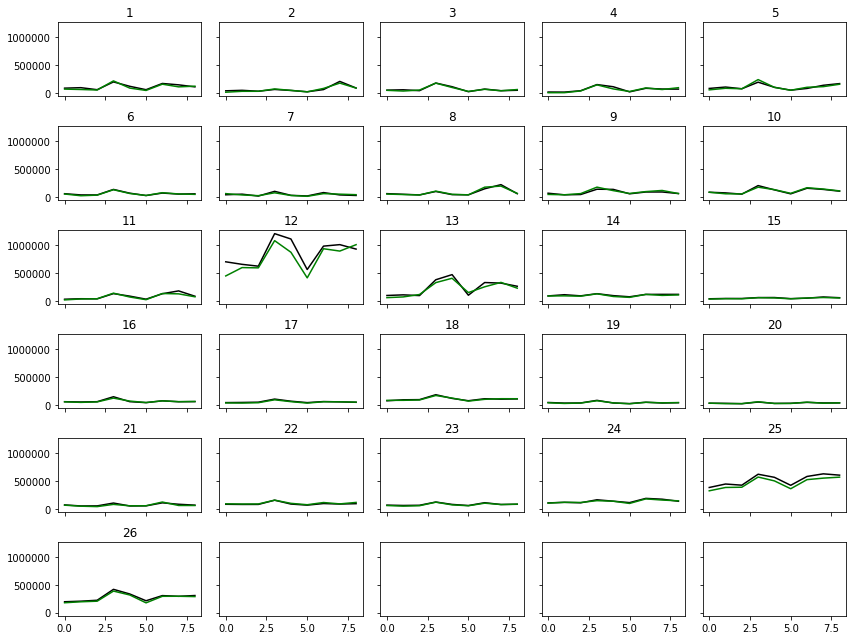

In [155]:
ncols = 5
fig, axes = plt.subplots(nrows=len(ts_pred.T)//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))

for ax, ya, yp, title in zip(axes.flat, ts[train_length:].T, ts_pred.T, range(1,len(ts_pred.T)+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.set_title(title)

plt.tight_layout()